# TP4 - DÉTECTION DE FRAUDE BANCAIRE
## Optimisation ML & Feature Engineering Avancé

**Master 1 Data Engineering - Concepts & Techno IA** 
**Durée : 7 heures** 
**Nom & Prénom : KOUYATE Issa**

---

### Objectifs
- Maîtriser le Feature Engineering avancé
- Gérer des données fortement déséquilibrées (0.17% de fraudes)
- Optimiser des hyperparamètres avec GridSearchCV
- Construire des Pipelines ML complets
- Analyser la performance (ROC, Learning Curves, Feature Importance)

### Mission
Développer un modèle de détection de fraude avec :
- **Recall ≥ 0.85** (détecter 85% des fraudes)
- **Precision maximale** (minimiser les faux positifs)
- **Explicabilité** (Feature Importance)

---

## IMPORTS & CONFIGURATION

In [1]:
# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration visualisation
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(" Imports réussis")

 Imports réussis


In [2]:
# Imports ML
from sklearn.model_selection import (
 train_test_split, StratifiedKFold, TimeSeriesSplit,
 GridSearchCV, cross_val_score, learning_curve
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Métriques
from sklearn.metrics import (
 classification_report, confusion_matrix, ConfusionMatrixDisplay,
 roc_auc_score, average_precision_score, precision_recall_curve,
 roc_curve, auc, f1_score, precision_score, recall_score
)

# Gestion déséquilibre
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

print(" Imports ML réussis")

 Imports ML réussis


---
## PARTIE 1 : EXPLORATION & FEATURE ENGINEERING (2h)
---

### 1.1 Chargement des Données

In [3]:
# TODO: Charger le dataset creditcard.csv depuis le dossier ../data/

df = pd.read_csv('../data/creditcard.csv')

# Afficher les informations
print(f"Shape: {df.shape}")
df.head()

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Informations du dataset
print(df.info())
print(df.describe())
print("\nValeurs manquantes:", df.isnull().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### 1.2 Analyse du Déséquilibre

In [5]:
# TODO: Calculer et afficher :
# - Nombre de transactions légitimes (Class = 0)
# - Nombre de fraudes (Class = 1)
# - Pourcentage de fraudes
# - Ratio fraudes/légitimes

legit_count = (df['Class'] == 0).sum()
fraud_count = (df['Class'] == 1).sum()
fraud_percentage = fraud_count / len(df) * 100

print(f"Transactions légitimes: {legit_count:,}")
print(f"Fraudes: {fraud_count:,}")
print(f"Pourcentage de fraudes: {fraud_percentage:.3f}%")
print(f"Ratio (1 fraude pour X légitimes): 1:{legit_count/fraud_count:.0f}")

Transactions légitimes: 284,315
Fraudes: 492
Pourcentage de fraudes: 0.173%
Ratio (1 fraude pour X légitimes): 1:578


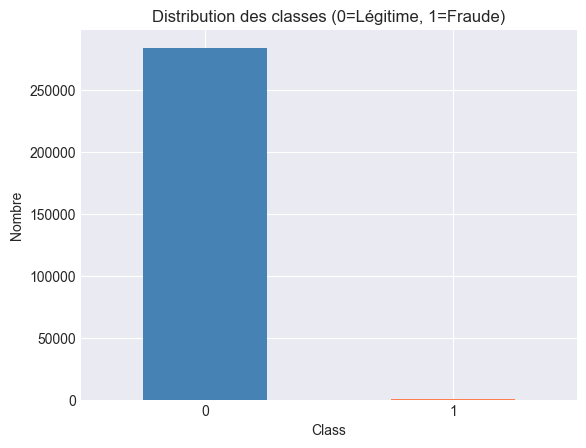

In [6]:
# Bar plot distribution des classes
df['Class'].value_counts().plot(kind='bar', color=['steelblue', 'coral'])
plt.title('Distribution des classes (0=Légitime, 1=Fraude)')
plt.xlabel('Class')
plt.ylabel('Nombre')
plt.xticks(rotation=0)
plt.show()


### QUESTION 1
**Analysez les résultats ci-dessus et répondez :**

1. Quel est le ratio fraudes/légitimes ? Est-ce un déséquilibre important ?
2. Pourquoi ce déséquilibre est-il un problème pour le Machine Learning ?
3. Quelles techniques pouvez-vous utiliser pour gérer ce déséquilibre ?

**Vos réponses :**

```
1. ...

2. ...

3. ...
```

### 1.3 Analyse des Distributions

In [7]:
# TODO: Comparer les statistiques (mean, std, min, max) pour Amount et Time
# entre fraudes et transactions légitimes

print("="*60)
print("TRANSACTIONS LÉGITIMES")
print("="*60)
print(df[df['Class']==0][['Amount','Time']].describe())

print("\n" + "="*60)
print("FRAUDES")
print("="*60)
print(df[df['Class']==1][['Amount','Time']].describe())

TRANSACTIONS LÉGITIMES
              Amount           Time
count  284315.000000  284315.000000
mean       88.291022   94838.202258
std       250.105092   47484.015786
min         0.000000       0.000000
25%         5.650000   54230.000000
50%        22.000000   84711.000000
75%        77.050000  139333.000000
max     25691.160000  172792.000000

FRAUDES
            Amount           Time
count   492.000000     492.000000
mean    122.211321   80746.806911
std     256.683288   47835.365138
min       0.000000     406.000000
25%       1.000000   41241.500000
50%       9.250000   75568.500000
75%     105.890000  128483.000000
max    2125.870000  170348.000000


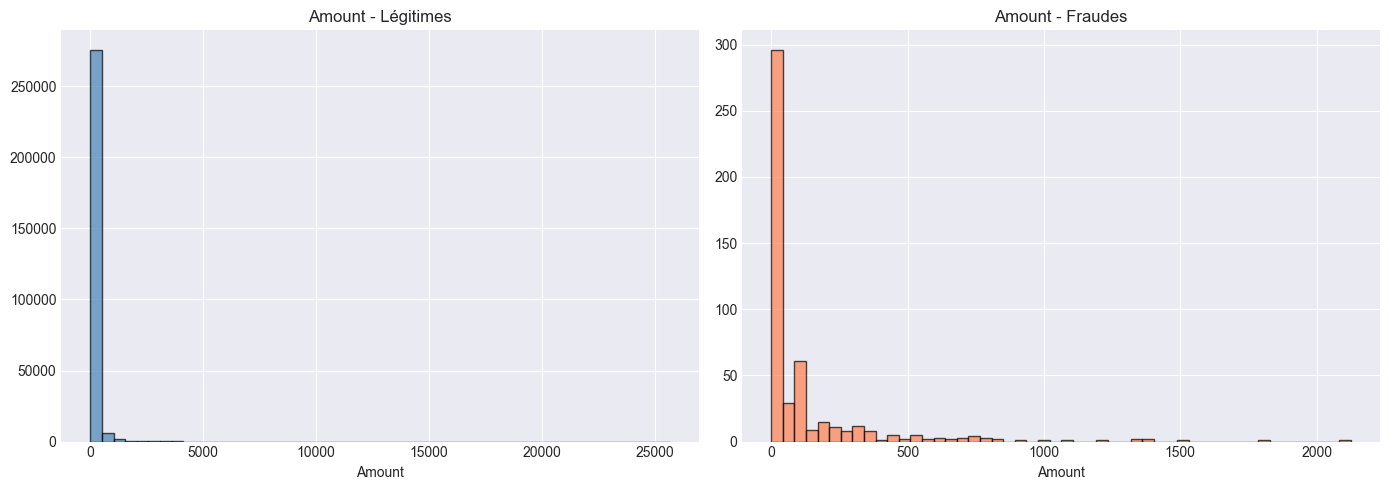

In [8]:
# TODO: Créer 2 histogrammes côte à côte pour visualiser la distribution de Amount
# Un pour les légitimes, un pour les fraudes

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df[df['Class']==0]['Amount'].hist(ax=axes[0], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Amount - Légitimes')
axes[0].set_xlabel('Amount')
df[df['Class']==1]['Amount'].hist(ax=axes[1], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Amount - Fraudes')
axes[1].set_xlabel('Amount')
plt.tight_layout()
plt.show()


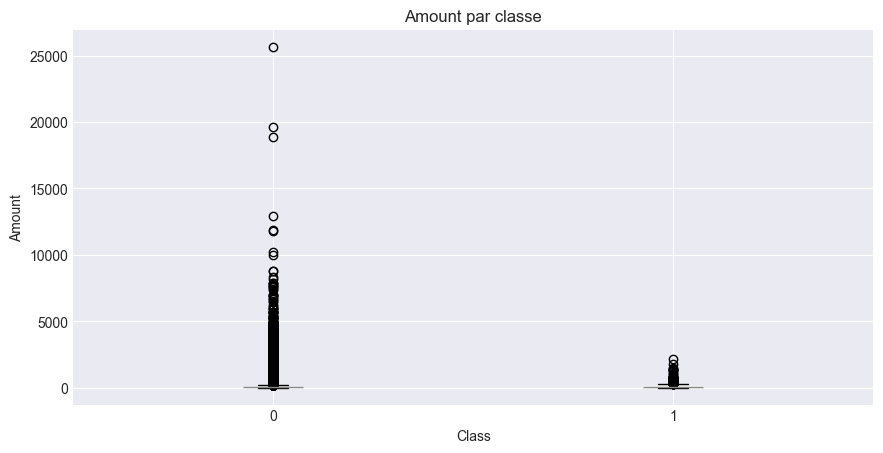

In [9]:
# Boxplots Amount par classe
plt.figure(figsize=(10, 5))
df.boxplot(column='Amount', by='Class', ax=plt.gca())
plt.suptitle('')
plt.title('Amount par classe')
plt.ylabel('Amount')
plt.show()


### 1.4 Analyse de Corrélation

In [10]:
# TODO: Calculer la corrélation de toutes les features avec 'Class'
# Afficher les 10 features les plus corrélées (en valeur absolue)

correlations = df.corr()['Class'].abs().sort_values(ascending=False)
correlations = correlations.drop('Class')
top10_corr = correlations.head(10)
print("Top 10 Features corrélées avec Class:")
print(top10_corr)

Top 10 Features corrélées avec Class:
V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64


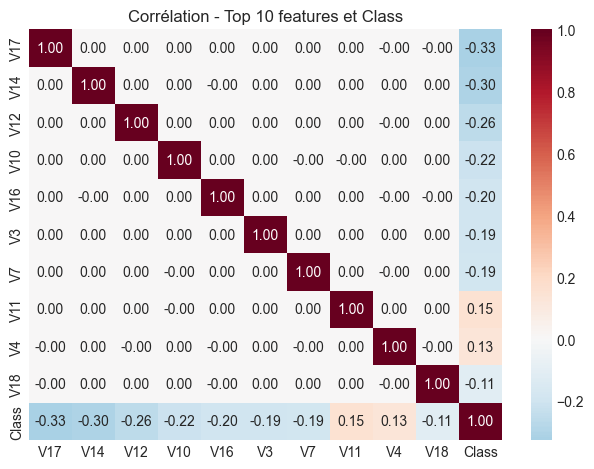

In [11]:
# Heatmap top 10 features + Class
cols_heat = top10_corr.index.tolist() + ['Class']
sns.heatmap(df[cols_heat].corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Corrélation - Top 10 features et Class')
plt.tight_layout()
plt.show()


### QUESTION 2
**Analysez les corrélations :**

1. Quelles sont les 3 features PCA les plus corrélées avec Class ?
2. Les fraudes ont-elles des montants typiques différents des transactions légitimes ?
3. Y a-t-il des patterns temporels visibles ?

**Vos réponses :**

```
1. ...

2. ...

3. ...
```

### 1.4bis Analyse Temporelle Approfondie

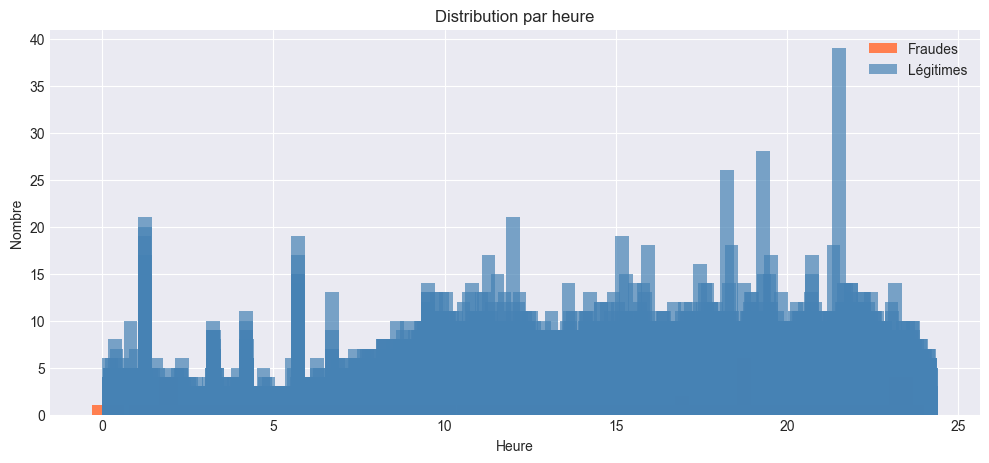

In [12]:
# Distribution des fraudes par heure (hour = Time/3600 % 24)
df['hour'] = (df['Time'] / 3600) % 24
fraud_by_hour = df[df['Class']==1].groupby('hour').size()
legit_by_hour = df[df['Class']==0].groupby('hour').size()
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(fraud_by_hour.index - 0.2, fraud_by_hour.values, 0.4, label='Fraudes', color='coral')
ax.bar(legit_by_hour.index + 0.2, legit_by_hour.values, 0.4, label='Légitimes', color='steelblue', alpha=0.7)
ax.set_xlabel('Heure')
ax.set_ylabel('Nombre')
ax.set_title('Distribution par heure')
ax.legend()
plt.show()


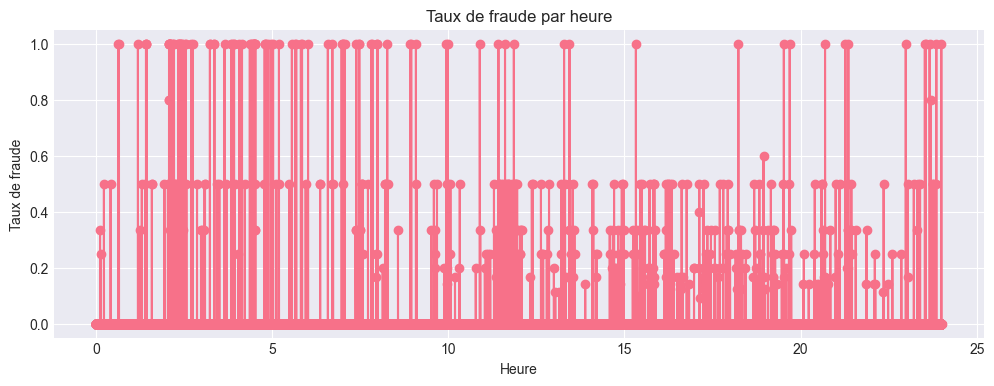

In [13]:
# Taux de fraude par heure
total_by_hour = df.groupby('hour').size()
fraud_by_h = df[df['Class']==1].groupby('hour').size()
taux_fraude = fraud_by_h.reindex(total_by_hour.index, fill_value=0) / total_by_hour
plt.figure(figsize=(12, 4))
plt.plot(taux_fraude.index, taux_fraude.values, marker='o')
plt.xlabel('Heure')
plt.ylabel('Taux de fraude')
plt.title('Taux de fraude par heure')
plt.grid(True)
plt.show()


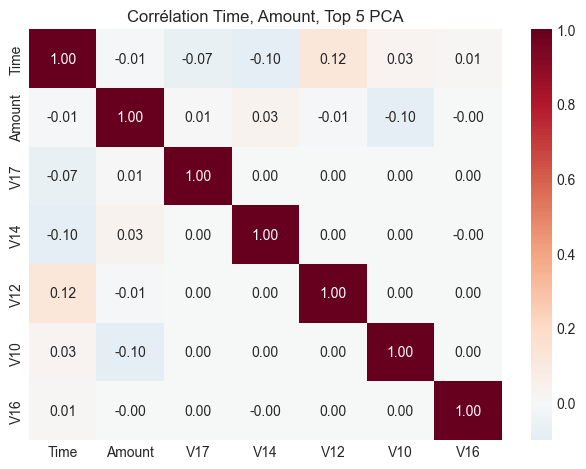

In [14]:
# Heatmap Time, Amount, top 5 PCA
top5_pca = top10_corr.head(5).index.tolist()
cols_hm = ['Time', 'Amount'] + top5_pca
sns.heatmap(df[cols_hm].corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Corrélation Time, Amount, Top 5 PCA')
plt.tight_layout()
plt.show()


---
### 1.5 Feature Engineering Avancé
**Mission : Créer au minimum 15 nouvelles features pertinentes**

In [15]:
# Créer une copie pour le feature engineering
df_fe = df.copy()

print(f"Shape initiale: {df_fe.shape}")

Shape initiale: (284807, 32)


#### Features Temporelles (et toutes les autres via utils)

In [16]:
# Utiliser create_features du module utils (livrable sujet)
import sys
sys.path.insert(0, '..')
from utils.feature_engineering import create_features, get_top_correlated_features

top3_corr = get_top_correlated_features(df, 'Class', 5)[:3]
df_fe = create_features(df_fe, top3_corr)
print("Features créées (temporelles, montants, interactions, agrégations, écarts):", df_fe.shape[1] - df.shape[1])
df_fe[['Time', 'hour', 'day', 'hour_sin', 'hour_cos']].head()

Features créées (temporelles, montants, interactions, agrégations, écarts): 21


,Time,hour,day,hour_sin,hour_cos
0,0.0,0.000000,0.000000,0.000000,1.0
1,0.0,0.000000,0.000000,0.000000,1.0
2,1.0,0.000278,0.000012,0.000073,1.0
3,1.0,0.000278,0.000012,0.000073,1.0
4,2.0,0.000556,0.000023,0.000145,1.0


In [17]:
# period déjà créé par create_features()
print("Distribution des périodes:")
print(df_fe['period'].value_counts())

Distribution des périodes:
period
afternoon    96435
evening      93526
morning      70912
night        23934
Name: count, dtype: int64


#### Features sur les Montants

In [18]:
# amount_log, amount_sqrt, is_zero_amount déjà créés par create_features()
print("Features montants:", [c for c in ['amount_log','amount_sqrt','is_zero_amount'] if c in df_fe.columns])

Features montants: ['amount_log', 'amount_sqrt', 'is_zero_amount']


In [ ]:
# amount_bin déjà créé par create_features()
print("Distribution des bins:")
print(df_fe['amount_bin'].value_counts())

#### Features d'Interaction

In [ ]:
# Interactions (V_i * Amount, amount_per_hour, time_amount_ratio) déjà créées par create_features()
print("Features d'interaction créées")

In [ ]:
# pca_sum_top5, pca_mean_top5, pca_std déjà créés par create_features()
print("Features d'agrégation créées")

#### Features Polynomiales et Ratios

In [ ]:
# amount_squared, amount_cubed déjà créés par create_features()
print("Features polynomiales créées")

In [ ]:
# amount_per_hour, time_amount_ratio déjà créés par create_features()
print("Features de ratio créées")

In [ ]:
# deviation_Vi déjà créées par create_features() pour les 3 PCA les plus corrélées
print("Features d'écart créées")

#### Validation des Nouvelles Features

In [ ]:
# Compter les nouvelles features créées
original_features = df.shape[1]
new_features_count = df_fe.shape[1] - original_features

print(f"Features originales: {original_features}")
print(f"Nouvelles features créées: {new_features_count}")
print(f"Total features: {df_fe.shape[1]}")

# Lister les nouvelles features
new_features = [col for col in df_fe.columns if col not in df.columns]
print(f"\nNouvelles features: {new_features}")

In [ ]:
# Corrélation des nouvelles features avec Class
new_cols = [c for c in df_fe.columns if c not in df.columns]
corr_new = df_fe[new_cols + ['Class']].corr()['Class'].abs().drop('Class').sort_values(ascending=False)
print("Corrélation des nouvelles features avec Class:")
print(corr_new)

### QUESTION 3
**Justifiez vos choix de Feature Engineering :**

1. Quelles features créées sont les plus prometteuses (corrélation) ?
2. Pourquoi l'encodage cyclique (sin/cos) est-il pertinent pour l'heure ?
3. Quel est l'intérêt métier de créer des interactions Amount × V_i ?

**Vos réponses :**

```
1. ...

2. ...

3. ...
```

---
## PARTIE 2 : MODÉLISATION BASELINE (1h30)
---

### 2.1 Préparation des Données

In [ ]:
# Séparer X et y - encoder les catégorielles (period, amount_bin)
df_enc = pd.get_dummies(df_fe, columns=['period', 'amount_bin'], drop_first=True)
y = df_enc['Class']
X = df_enc.drop(columns=['Class'])
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

In [ ]:
# Split Train/Test 80/20 stratifié
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nDistribution dans le train:")
print(y_train.value_counts())
print(f"\nDistribution dans le test:")
print(y_test.value_counts())

In [ ]:
# Scaling: RobustScaler (résistant aux outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Scaling effectué")

### QUESTION 4
**Justifiez votre choix de scaler :**

```
J'ai choisi [StandardScaler/RobustScaler] parce que...
```

### 2.2 Modèles Baseline

In [ ]:
# Fonction utilitaire pour évaluer un modèle
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
 """
 Entraîne et évalue un modèle
 
 Returns:
 dict: Dictionnaire avec les métriques
 """
 print(f"\n{'='*60}")
 print(f"ÉVALUATION: {model_name}")
 print(f"{'='*60}")
 
 model.fit(X_train, y_train)
 y_pred = model.predict(X_test)
 y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
 cm = confusion_matrix(y_test, y_pred)
 print(classification_report(y_test, y_pred))
 print("Confusion matrix:", cm)
 pr = precision_score(y_test, y_pred, zero_division=0)
 rc = recall_score(y_test, y_pred, zero_division=0)
 f1 = f1_score(y_test, y_pred, zero_division=0)
 roc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else 0.5
 pr_auc = average_precision_score(y_test, y_proba)
 print(f"Precision: {pr:.4f}, Recall: {rc:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}, PR-AUC: {pr_auc:.4f}")
 return {'Model': model_name, 'Precision': pr, 'Recall': rc, 'F1': f1, 'ROC-AUC': roc, 'PR-AUC': pr_auc}

print("Fonction d'évaluation créée")

#### Modèle 1 : Logistic Regression

In [ ]:
# Logistic Regression avec class_weight='balanced'
lr_model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)
lr_results = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")

#### Modèle 2 : Decision Tree

In [ ]:
# Decision Tree max_depth=10, class_weight='balanced'
dt_model = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=RANDOM_STATE)
dt_results = evaluate_model(dt_model, X_train_scaled, X_test_scaled, y_train, y_test, "Decision Tree")

#### Modèle 3 : Random Forest

In [ ]:
# Random Forest n_estimators=100, class_weight='balanced'
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
rf_results = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")

#### Modèle 4 : Support Vector Machine (SVM)

In [ ]:
# SVM kernel rbf, class_weight balanced
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=RANDOM_STATE, probability=True)
svm_results = evaluate_model(svm_model, X_train_scaled, X_test_scaled, y_train, y_test, "SVM")

#### Modèle 5 : K-Nearest Neighbors (KNN)

In [ ]:
# KNN n_neighbors=5, weights='distance'
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_results = evaluate_model(knn_model, X_train_scaled, X_test_scaled, y_train, y_test, "KNN")

#### Modèle 6 : XGBoost (Baseline)

In [ ]:
# XGBoost baseline avec scale_pos_weight
from xgboost import XGBClassifier
scale_pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
print(f"Scale pos weight: {scale_pos_weight:.2f}")
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, eval_metric='logloss')
xgb_results = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost")

### 2.3 Comparaison des Modèles Baseline

In [ ]:
# Tableau comparatif des 6 modèles
comparison_df = pd.DataFrame([lr_results, dt_results, rf_results, svm_results, knn_results, xgb_results]).set_index('Model')

print("\n" + "="*60)
print("COMPARAISON DES MODÈLES BASELINE")
print("="*60)
print(comparison_df)

In [ ]:
# Bar plot Precision, Recall, F1, PR-AUC pour les 6 modèles
comparison_df[['Precision','Recall','F1','PR-AUC']].plot(kind='bar', figsize=(12, 5))
plt.title('Comparaison des modèles baseline')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### 2.4 Comparaison des Stratégies de Rééquilibrage

In [ ]:
# TODO: Comparer class_weight='balanced' vs SMOTE
# Prendre le meilleur modèle baseline et tester avec SMOTE
# Formule SMOTE: Génère des exemples synthétiques pour la classe minoritaire
# Pour chaque exemple minoritaire x_i, choisir k voisins et créer:
# x_new = x_i + λ * (x_neighbor - x_i) où λ ∈ [0,1]

from imblearn.over_sampling import SMOTE

# Appliquer SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Avant SMOTE: {y_train.value_counts().to_dict()}")
print(f"Après SMOTE: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Entraîner le meilleur modèle (RF) avec SMOTE
rf_smote = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test_scaled)
smote_results = evaluate_model(rf_smote, X_train_smote, X_test_scaled, y_train_smote, y_test, 'RF avec SMOTE')


In [ ]:
# Tableau class_weight vs SMOTE (RF)
strat_df = pd.DataFrame([rf_results, smote_results]).set_index('Model')
print("Stratégie | Precision | Recall | F1 | PR-AUC")
print(strat_df[['Precision','Recall','F1','PR-AUC']])


### QUESTION 5
**Analysez les résultats baseline :**

1. Parmi les 6 modèles testés, lequel a le meilleur Recall ? Est-ce suffisant (objectif ≥ 0.85) ?
2. Pourquoi PR-AUC est-il plus pertinent que ROC-AUC ici ?
3. Comparez class_weight vs SMOTE. Quelle stratégie est la plus efficace ?
4. Quel modèle choisiriez-vous pour l'optimisation ? Pourquoi ?

**Vos réponses :**

```
1. ...

2. ...

3. ...

4. ...
```

---
## PARTIE 3 : OPTIMISATION AVANCÉE (2h)
---

**Note** : Cette partie peut prendre du temps (GridSearch = 15-30 min). Commencez par une petite grille pour tester !

### 3.1 Construction d'un Pipeline ML Complet

In [ ]:
# Pipeline: RobustScaler + Random Forest
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE))
])

print(" Pipeline créé")
print(pipeline)

### 3.2 Optimisation Hyperparamètres - GridSearchCV

In [ ]:
# TODO: Définir une grille de paramètres pour Random Forest
# IMPORTANT: Préfixer les paramètres avec 'classifier__' car dans un pipeline
# Commencez PETIT pour tester (2-3 valeurs par paramètre max)
# Exemple:
# param_grid = {
# 'classifier__n_estimators': [100, 200],
# 'classifier__max_depth': [10, None],
# 'classifier__min_samples_split': [2, 5],
# 'classifier__class_weight': ['balanced']
# }

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced']
}

n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"Nombre de combinaisons: {n_combinations}")
print(f"Avec cv=5 → {n_combinations * 5} entraînements")

In [ ]:
# GridSearchCV avec StratifiedKFold, scoring PR-AUC
grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='average_precision', n_jobs=-1, verbose=2)

print(" GridSearchCV configuré")

In [ ]:
# Lancer GridSearch (X_train, y_train non scalés - le pipeline scale)
import time
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_time = (end_time - start_time) / 60
print(f"\nTemps d'exécution: {grid_time:.2f} minutes")

In [ ]:
# Résultats GridSearch
print("="*60)
print("RÉSULTATS GRIDSEARCH")
print("="*60)
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score CV (PR-AUC):", grid_search.best_score_)
y_pred_gs = grid_search.best_estimator_.predict(X_test)
print("PR-AUC test:", average_precision_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1]))


### 3.3 Optimisation avec RandomizedSearchCV

In [ ]:
# TODO: Comparer GridSearchCV vs RandomizedSearchCV
# RandomizedSearchCV teste n_iter combinaisons aléatoires au lieu de toutes
# Avantage: Plus rapide, peut explorer un espace plus large
# Formule: Probabilité de trouver le top 5% en testant n combinaisons aléatoires:
# P = 1 - (0.95)^n
# Exemple: n=20 → P ≈ 64%, n=60 → P ≈ 95%

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Définir des distributions de paramètres (plus larges que GridSearch)
param_distributions = {
 'classifier__n_estimators': randint(50, 300),
 'classifier__max_depth': [5, 10, 15, 20, 25, None],
 'classifier__min_samples_split': randint(2, 20),
 'classifier__min_samples_leaf': randint(1, 10),
 'classifier__max_features': ['sqrt', 'log2', None],
 'classifier__class_weight': ['balanced']
}

# Configurer RandomizedSearchCV
random_search = RandomizedSearchCV(
 pipeline,
 param_distributions,
 n_iter=30, # Tester 30 combinaisons aléatoires
 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
 scoring='average_precision',
 n_jobs=-1,
 random_state=RANDOM_STATE,
 verbose=2
)

print("RandomizedSearchCV configuré")

In [ ]:
# Lancer RandomizedSearchCV
import time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
random_time = (end_time - start_time) / 60
print(f"\nTemps d'exécution: {random_time:.2f} minutes")

# Afficher les résultats
print("\n" + "="*60)
print("RÉSULTATS RANDOMIZEDSEARCH")
print("="*60)
print(f"Meilleurs paramètres: {random_search.best_params_}")
print(f"Meilleur score (CV): {random_search.best_score_:.4f}")

In [ ]:
# Comparaison GridSearch vs RandomizedSearch
comparaison_search = pd.DataFrame({
    'Méthode': ['GridSearchCV', 'RandomizedSearchCV'],
    'Meilleur_Score': [grid_search.best_score_, random_search.best_score_],
    'Temps_min': [grid_time, random_time],
    'Nb_Combinaisons': [n_combinations, 30]
})

print("\n" + "="*60)
print("COMPARAISON DES MÉTHODES D'OPTIMISATION")
print("="*60)
print(comparaison_search)

### 3.4 Optimisation de XGBoost

In [ ]:
# TODO: Optimiser XGBoost avec RandomizedSearchCV
# Créer un pipeline avec XGBoost
# Paramètres à optimiser:
# - n_estimators: [50, 100, 200, 300]
# - max_depth: [3, 5, 7, 9]
# - learning_rate: [0.01, 0.05, 0.1, 0.3]
# - subsample: [0.6, 0.8, 1.0]
# - colsample_bytree: [0.6, 0.8, 1.0]
# - scale_pos_weight: calculé automatiquement

pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, eval_metric='logloss'))
])
param_dist_xgb = {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [3, 5, 7], 'classifier__learning_rate': [0.01, 0.1], 'classifier__subsample': [0.8, 1.0], 'classifier__colsample_bytree': [0.8, 1.0]}
random_xgb = RandomizedSearchCV(pipeline_xgb, param_dist_xgb, n_iter=20, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='average_precision', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
random_xgb.fit(X_train, y_train)
print("Meilleurs params XGBoost:", random_xgb.best_params_)
print("Meilleur score:", random_xgb.best_score_)


### QUESTION 6
**Analysez l'optimisation :**

1. Quels hyperparamètres ont le plus d'impact sur la performance ?
2. Le gain de performance justifie-t-il le temps de calcul ?
3. GridSearch vs RandomizedSearch: quelle méthode est la plus efficace ?
4. XGBoost optimisé vs Random Forest optimisé: lequel est meilleur ?
5. Atteignez-vous l'objectif de Recall ≥ 0.85 ?

**Vos réponses :**

```
1. ...

2. ...

3. ...

4. ...

5. ...
```

---
## PARTIE 4 : ANALYSE & DIAGNOSTIC (1h)
---

### 4.1 Feature Importance

In [ ]:
# Meilleur modèle = pipeline optimisé (GridSearch)
best_model = grid_search.best_estimator_
rf_clf = best_model.named_steps['classifier']
feature_importances = rf_clf.feature_importances_
feat_imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances}).sort_values('importance', ascending=False)
print("Top 15 Features (MDI):")
print(feat_imp_df.head(15))


In [ ]:
# Bar plot horizontal Top 15 (MDI)
top15 = feat_imp_df.head(15)
plt.figure(figsize=(10, 6))
plt.barh(range(len(top15)), top15['importance'].values)
plt.yticks(range(len(top15)), top15['feature'].values)
plt.gca().invert_yaxis()
plt.xlabel('Importance (MDI)')
plt.title('Top 15 Features - Mean Decrease Impurity')
plt.tight_layout()
plt.show()


### 4.1bis Permutation Importance

In [ ]:
# Permutation Importance (best_model = pipeline, X_test pour cohérence)
# Principe: Mélanger aléatoirement une feature et mesurer la baisse de performance
# Formule: PI(f) = Score_original - Score_après_permutation(f)
# Plus PI est élevé, plus la feature est importante

from sklearn.inspection import permutation_importance

# Calculer la permutation importance
perm_importance = permutation_importance(
    best_model,
    X_test,
    y_test,
 n_repeats=10,
 random_state=RANDOM_STATE,
 scoring='average_precision'
)

# Créer un DataFrame
perm_imp_df = pd.DataFrame({
 'feature': X_train.columns,
 'importance_mean': perm_importance.importances_mean,
 'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Top 15 Features - Permutation Importance:")
print(perm_imp_df.head(15))

In [ ]:
# Comparaison MDI vs Permutation Importance (Top 15)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
top15_mdi = feat_imp_df.head(15)
axes[0].barh(range(15), top15_mdi['importance'].values)
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(top15_mdi['feature'].values)
axes[0].invert_yaxis()
axes[0].set_title('MDI')
top15_perm = perm_imp_df.head(15)
axes[1].barh(range(15), top15_perm['importance_mean'].values)
axes[1].set_yticks(range(15))
axes[1].set_yticklabels(top15_perm['feature'].values)
axes[1].invert_yaxis()
axes[1].set_title('Permutation Importance')
plt.tight_layout()
plt.show()


### 4.1ter SHAP Values (Explicabilité Avancée)

In [ ]:
# TODO: Calculer les SHAP values
# SHAP (SHapley Additive exPlanations) basé sur la théorie des jeux
# Formule de Shapley: φ_i = Σ [|S|!(n-|S|-1)!/n!] × [f(S∪{i}) - f(S)]
# où S sont tous les sous-ensembles de features sans i
# Interprétation: Contribution marginale moyenne de chaque feature

import shap

# Créer l'explainer (TreeExplainer pour Random Forest/XGBoost)
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])

# Calculer SHAP values sur un échantillon (100 premières lignes du test)
X_test_sample = X_test.iloc[:100]
shap_values = explainer.shap_values(X_test_sample)

print("SHAP values calculés")
print(f"Shape: {shap_values[1].shape if isinstance(shap_values, list) else shap_values.shape}")

In [ ]:
# TODO: Visualiser le summary plot SHAP
# Ce graphique montre:
# - L'importance de chaque feature (axe Y)
# - L'impact sur la prédiction (axe X)
# - La valeur de la feature (couleur: rouge=élevé, bleu=faible)

# Pour classification binaire, prendre shap_values[1] (classe positive)
shap_values_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

shap.summary_plot(shap_values_plot, X_test_sample, plot_type="dot", show=False)
plt.tight_layout()
plt.show()

In [ ]:
# TODO: Expliquer une prédiction individuelle
# Choisir une fraude correctement détectée et analyser pourquoi
# SHAP force plot montre la contribution de chaque feature à la prédiction

# Trouver un exemple de fraude
fraud_idx = y_test[y_test == 1].index[0]
fraud_sample_idx = X_test.index.get_loc(fraud_idx)

if fraud_sample_idx < 100: # Si dans notre échantillon
 print(f"Analyse de la transaction {fraud_idx} (Fraude)")
 print(f"Probabilité prédite: {best_model.predict_proba(X_test.iloc[[fraud_sample_idx]])[:,1][0]:.4f}")
 
 # Force plot
 shap.force_plot(
 explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
 shap_values_plot[fraud_sample_idx],
 X_test_sample.iloc[fraud_sample_idx],
 matplotlib=True,
 show=False
 )
 plt.tight_layout()
 plt.show()

### QUESTION 7
**Interprétez les Feature Importances :**

1. Les features créées (Feature Engineering) sont-elles utiles ?
2. Y a-t-il des surprises (features inattendues importantes) ?
3. MDI vs Permutation Importance: quelles différences observez-vous ?
4. SHAP: quelles features contribuent le plus aux prédictions de fraude ?
5. Pourrait-on simplifier le modèle en retirant des features peu importantes ?

**Vos réponses :**

```
1. ...

2. ...

3. ...

4. ...

5. ...
```

### 4.2 Courbes ROC et Precision-Recall

In [ ]:
# TODO: Tracer les courbes ROC et Precision-Recall côte à côte
# 1. Prédire les probabilités avec predict_proba()
# 2. Calculer les courbes avec roc_curve() et precision_recall_curve()
# 3. Visualiser avec plt.subplot(1, 2, 1) et plt.subplot(1, 2, 2)



### 4.3 Learning Curves

In [ ]:
# Learning Curves
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='average_precision', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
plt.xlabel('Taille train')
plt.ylabel('PR-AUC')
plt.legend()
plt.title('Learning Curves')
plt.show()


### 4.3bis Calibration des Probabilités

In [ ]:
# Probabilités du modèle optimisé pour calibration
y_proba_optimized = best_model.predict_proba(X_test)[:, 1]

# Courbe de calibration
# Un modèle bien calibré: si proba=0.8, alors 80% des prédictions sont correctes
# Méthode: Tracer la courbe de calibration (reliability diagram)
# Axe X: Probabilité prédite (bins)
# Axe Y: Fraction réelle de positifs dans chaque bin
# Ligne diagonale = calibration parfaite

from sklearn.calibration import calibration_curve

# Calculer la courbe de calibration
fraction_of_positives, mean_predicted_value = calibration_curve(
 y_test,
 y_proba_optimized,
 n_bins=10,
 strategy='uniform'
)

# Visualiser
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Modèle')
plt.plot([0, 1], [0, 1], 'k--', label='Calibration parfaite')
plt.xlabel('Probabilité prédite moyenne')
plt.ylabel('Fraction de positifs')
plt.title('Courbe de Calibration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interprétation:")
print("- Si proche de la diagonale: modèle bien calibré")
print("- Si au-dessus: modèle sous-estime les probabilités")
print("- Si en-dessous: modèle surestime les probabilités")

In [ ]:
# TODO: Appliquer la calibration si nécessaire
# Méthode: CalibratedClassifierCV avec Platt Scaling ou Isotonic Regression
# Platt Scaling: Ajuste une régression logistique sur les probabilités
# Formule: P_calibrated = 1 / (1 + exp(A × log(p/(1-p)) + B))
# Isotonic Regression: Ajuste une fonction monotone non-paramétrique

from sklearn.calibration import CalibratedClassifierCV

# Calibrer le modèle
calibrated_model = CalibratedClassifierCV(
 best_model,
 method='sigmoid', # Platt Scaling
 cv=5
)

# Entraîner sur le train
calibrated_model.fit(X_train, y_train)

# Prédire sur le test
y_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Comparer les performances
print("\nComparaison avant/après calibration:")
print(f"PR-AUC avant: {average_precision_score(y_test, y_proba_optimized):.4f}")
print(f"PR-AUC après: {average_precision_score(y_test, y_proba_calibrated):.4f}")

### QUESTION 8
**Diagnostiquez le modèle :**

1. Le modèle est-il en overfitting, underfitting ou bon fit ?
2. Le modèle bénéficierait-il de plus de données ?
3. Quelles actions recommanderiez-vous pour améliorer le modèle ?

**Vos réponses :**

```
1. ...

2. ...

3. ...
```

### 4.4 Optimisation du Seuil de Décision

In [ ]:
# Seuil optimal (F1-Score)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_optimized)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
print(f"Seuil optimal: {optimal_threshold:.4f}")
y_pred_05 = (y_proba_optimized >= 0.5).astype(int)
y_pred_opt = (y_proba_optimized >= optimal_threshold).astype(int)
print("Seuil 0.5 - Precision:", precision_score(y_test, y_pred_05), "Recall:", recall_score(y_test, y_pred_05), "F1:", f1_score(y_test, y_pred_05))
print("Seuil optimal - Precision:", precision_score(y_test, y_pred_opt), "Recall:", recall_score(y_test, y_pred_opt), "F1:", f1_score(y_test, y_pred_opt))


### QUESTION 9
**Analysez l'optimisation du seuil :**

1. Quel est l'impact sur Precision et Recall ?
2. Quel seuil recommanderiez-vous en production ? Pourquoi ?
3. Comment choisir entre privilégier Precision ou Recall selon le contexte métier ?

**Vos réponses :**

```
1. ...

2. ...

3. ...
```

---
## PARTIE 5 : DÉPLOIEMENT & PRODUCTION (1h)
---

### 5.1 Validation Temporelle (TimeSeriesSplit)

In [ ]:
# TimeSeriesSplit (données ordonnées par Time)
tscv = TimeSeriesSplit(n_splits=5)
scores_ts = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='average_precision', n_jobs=-1)
print("TimeSeriesSplit - PR-AUC mean:", scores_ts.mean(), "std:", scores_ts.std())
scores_skf = cross_val_score(best_model, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE), scoring='average_precision', n_jobs=-1)
print("StratifiedKFold - PR-AUC mean:", scores_skf.mean())


### 5.2 Sérialisation du Modèle

In [ ]:
# Sauvegarder le pipeline (meilleur modèle)
import joblib
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/fraud_detector_v1.joblib')
print("Modèle sauvegardé: ../models/fraud_detector_v1.joblib")


In [ ]:
# Métadonnées du modèle
metadata = {
    'model_version': '1.0',
    'random_state': RANDOM_STATE,
    'optimal_threshold': float(optimal_threshold),
    'pr_auc_test': float(average_precision_score(y_test, y_proba_optimized)),
    'n_features': X_train.shape[1]
}
joblib.dump(metadata, '../models/metadata_v1.joblib')
print("Métadonnées sauvegardées")


### 5.3 Test de Chargement et Prédiction

In [ ]:
# Test de chargement et prédiction
model_loaded = joblib.load('../models/fraud_detector_v1.joblib')
y_pred_loaded = model_loaded.predict(X_test.iloc[:5])
print("Prédictions (5 premiers test):", y_pred_loaded)
print("Vraies valeurs:", y_test.iloc[:5].values)


### 5.4 Création d'une API de Prédiction (Flask)

In [ ]:
# TODO: Créer un script Flask pour l'API
# Structure:
# - Endpoint POST /predict
# - Input: JSON avec les features d'une transaction
# - Output: JSON avec {"is_fraud": bool, "probability": float, "risk_level": str}

# Créer le fichier api_fraud_detection.py
api_code = '''
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

app = Flask(__name__)

# Charger le modèle au démarrage
model = joblib.load('models/fraud_detector_v1.joblib')
metadata = joblib.load('models/metadata_v1.joblib')

@app.route('/predict', methods=['POST'])
def predict():
 """
 Endpoint de prédiction
 Input JSON: {"Time": float, "V1": float, ..., "Amount": float}
 Output JSON: {"is_fraud": bool, "probability": float, "risk_level": str}
 """
 try:
 # Récupérer les données
 data = request.get_json()
 
 # Convertir en DataFrame
 df = pd.DataFrame([data])
 
 # Prédire
 proba = model.predict_proba(df)[:, 1][0]
 threshold = metadata.get('optimal_threshold', 0.5)
 is_fraud = proba >= threshold
 
 # Déterminer le niveau de risque
 if proba < 0.3:
 risk_level = 'low'
 elif proba < 0.6:
 risk_level = 'medium'
 elif proba < 0.85:
 risk_level = 'high'
 else:
 risk_level = 'critical'
 
 # Retourner la réponse
 return jsonify({
 'is_fraud': bool(is_fraud),
 'probability': float(proba),
 'risk_level': risk_level,
 'threshold_used': float(threshold)
 })
 
 except Exception as e:
 return jsonify({'error': str(e)}), 400

@app.route('/health', methods=['GET'])
def health():
 """Endpoint de santé"""
 return jsonify({'status': 'ok', 'model_version': metadata.get('model_version', 'unknown')})

if __name__ == '__main__':
 app.run(host='0.0.0.0', port=5000, debug=False)
'''

# Sauvegarder le fichier
with open('../api_fraud_detection.py', 'w') as f:
 f.write(api_code)

print("API Flask créée: ../api_fraud_detection.py")
print("\nPour lancer l'API:")
print(" python api_fraud_detection.py")
print("\nPour tester:")
print(" curl -X POST http://localhost:5000/predict -H 'Content-Type: application/json' -d '{...}'")

### 5.5 Tests Unitaires du Modèle

In [ ]:
# TODO: Créer des tests unitaires pour valider le modèle
# Tests à implémenter:
# 1. Test de chargement du modèle
# 2. Test de prédiction sur des données valides
# 3. Test de robustesse (valeurs manquantes, outliers)
# 4. Test de performance (temps de prédiction < 100ms)

import unittest
import time

class TestFraudDetector(unittest.TestCase):
 
 @classmethod
 def setUpClass(cls):
 """Charger le modèle une fois pour tous les tests"""
 cls.model = joblib.load('../models/fraud_detector_v1.joblib')
 cls.sample_data = X_test.iloc[:10]
 
 def test_model_loading(self):
 """Test: Le modèle se charge correctement"""
 self.assertIsNotNone(self.model)
 print("Test chargement: OK")
 
 def test_prediction_shape(self):
 """Test: Les prédictions ont la bonne forme"""
 predictions = self.model.predict(self.sample_data)
 self.assertEqual(len(predictions), len(self.sample_data))
 print("Test shape prédictions: OK")
 
 def test_prediction_values(self):
 """Test: Les prédictions sont dans [0, 1]"""
 probas = self.model.predict_proba(self.sample_data)[:, 1]
 self.assertTrue(all(0 <= p <= 1 for p in probas))
 print("Test valeurs prédictions: OK")
 
 def test_prediction_time(self):
 """Test: Temps de prédiction < 100ms pour 10 transactions"""
 start = time.time()
 _ = self.model.predict(self.sample_data)
 elapsed = (time.time() - start) * 1000 # en ms
 self.assertLess(elapsed, 100)
 print(f"Test temps prédiction: {elapsed:.2f}ms < 100ms OK")

# Exécuter les tests
if __name__ == '__main__':
 suite = unittest.TestLoader().loadTestsFromTestCase(TestFraudDetector)
 runner = unittest.TextTestRunner(verbosity=2)
 result = runner.run(suite)
 
 print(f"\nTests exécutés: {result.testsRun}")
 print(f"Succès: {result.testsRun - len(result.failures) - len(result.errors)}")
 print(f"Échecs: {len(result.failures)}")
 print(f"Erreurs: {len(result.errors)}")

---
## SYNTHÈSE FINALE
---

### QUESTION 10 - BILAN GLOBAL
**Rédigez une synthèse de votre travail (10-15 lignes) :**

1. **Performance finale** : Avez-vous atteint les objectifs (Recall ≥ 0.85, Precision maximale) ?
2. **Feature Engineering** : Quelles features créées ont été les plus utiles ?
3. **Optimisation** : Quel a été l'impact de GridSearch et de l'ajustement du seuil ?
4. **Déploiement** : Le modèle est-il prêt pour la production ? Quelles précautions ?
5. **Améliorations futures** : Que pourriez-vous faire pour améliorer encore le modèle ?

**Votre synthèse :**

```
...
```

---
## BONUS (Optionnel)
---

Si vous avez terminé en avance, voici quelques pistes pour aller plus loin :

### Bonus 1 : XGBoost

In [ ]:
# TODO: Tester XGBoost avec optimisation des hyperparamètres
# Paramètre clé: scale_pos_weight (ratio des classes)

from xgboost import XGBClassifier

# À compléter

### Bonus 2 : SHAP Values

In [ ]:
# TODO: Utiliser SHAP pour expliquer les prédictions
# import shap

# À compléter

### Bonus 3 : Voting Classifier

In [ ]:
# TODO: Combiner plusieurs modèles avec VotingClassifier
# from sklearn.ensemble import VotingClassifier

# À compléter

---
## FIN DU TP

**Félicitations ! **

Vous avez complété un pipeline ML complet de détection de fraude, de l'exploration à la production.

**N'oubliez pas de :**
- Sauvegarder ce notebook
- Vérifier que tous les fichiers sont créés (modèle, métadonnées)
- Répondre à toutes les 10 questions
- Compléter les modules Python si demandé (`utils/predict.py`)

---

**Master 1 Data Engineering - YNOV Montpellier** 
**Date** : Décembre 2025

---